# Modelo de Red Neuronal y LSTM para predecir valores de calidad del agua

## Importar librerias

Para esta sesión, utilizaremos varias bibliotecas de Python esenciales para el análisis de datos y el aprendizaje automático:

In [37]:
import pandas as pd  # Manejo y análisis de datos estructurados (DataFrames)
import numpy as np  # Cálculos numéricos y operaciones con arreglos

%matplotlib inline
import matplotlib.pyplot as plt  # Biblioteca para visualización de datos

from sklearn.preprocessing import MinMaxScaler  # Normalización de datos entre 0 y 1
from sklearn.metrics import r2_score  # Métrica para evaluar el rendimiento del modelo

from keras.models import Sequential  # Modelo secuencial en Keras (red neuronal paso a paso)
from keras.layers import Dense  # Capa completamente conectada para redes neuronales
from keras.layers import LSTM  # Capa de red neuronal recurrente para series temporales

from keras.callbacks import EarlyStopping  # Detiene el entrenamiento si no hay mejoras
from keras.optimizers import Adam  # Optimizador eficiente para ajuste de pesos


## Carga de Datos desde un Archivo CSV

Para trabajar con nuestros datos, primero debemos cargarlos en un DataFrame de Pandas.


In [42]:
df_pH = pd.read_csv("georgia.csv",usecols=['date','pH'])
# Carga el archivo CSV llamado "georgia.csv"  
# Solo selecciona las columnas 'date' (fecha) y 'pH' (nivel de pH del agua)

df_pH.head(10)

,date,pH
0,2014-10-01,7.009447
1,2014-10-02,7.044741
2,2014-10-03,6.972112
3,2014-10-04,6.928980
4,2014-10-05,6.980445
5,2014-10-06,7.019258
6,2014-10-07,7.031518
7,2014-10-08,7.031793
8,2014-10-09,7.013097
9,2014-10-10,7.007799


In [43]:
df_pH['date'] = pd.to_datetime(df_pH['date'])  
# Convierte la columna 'date' a formato datetime para facilitar el análisis temporal

df_pH = df_pH.set_index(['date'], drop=True)  
# Establece la columna 'date' como índice del DataFrame  
# drop=True elimina la columna original después de establecerla como índice


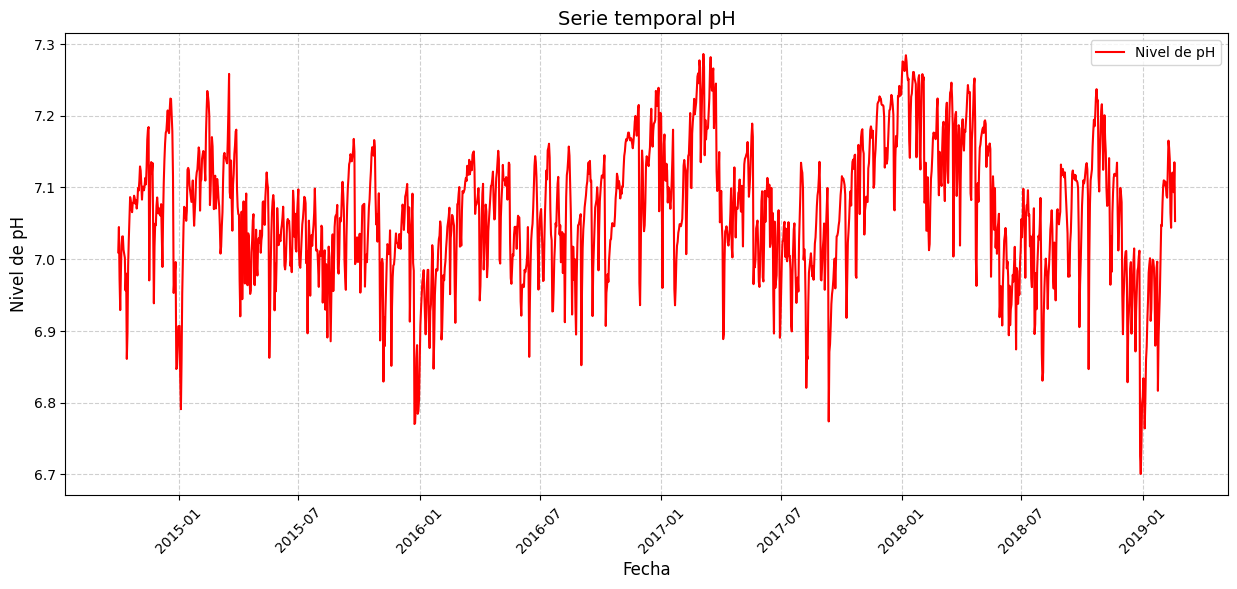

In [52]:
plt.figure(figsize=(15, 6))  # Define el tamaño de la figura (15 de ancho, 6 de alto)

plt.plot(df_pH.index, df_pH['pH'], color='r', linestyle='-', markersize=4, label='Nivel de pH')  
# Grafica la serie temporal de pH con una línea azul, marcadores circulares y una leyenda

plt.title('Serie temporal pH', fontsize=14)  # Título del gráfico
plt.xlabel('Fecha', fontsize=12)  # Etiqueta del eje X
plt.ylabel('Nivel de pH', fontsize=12)  # Etiqueta del eje Y
plt.grid(True, linestyle='--', alpha=0.6)  # Agrega una cuadrícula punteada para mejor visualización
plt.legend()  # Muestra la leyenda del gráfico
plt.xticks(rotation=45)  # Rota las fechas en el eje X para mejor legibilidad

plt.show()  # Muestra el gráfico


## División de Datos en Entrenamiento y Prueba

Para evaluar el rendimiento del modelo, dividimos los datos en dos conjuntos:
- **Entrenamiento** (antes del 1 de junio de 2018).
- **Prueba** (desde el 1 de junio de 2018 en adelante).

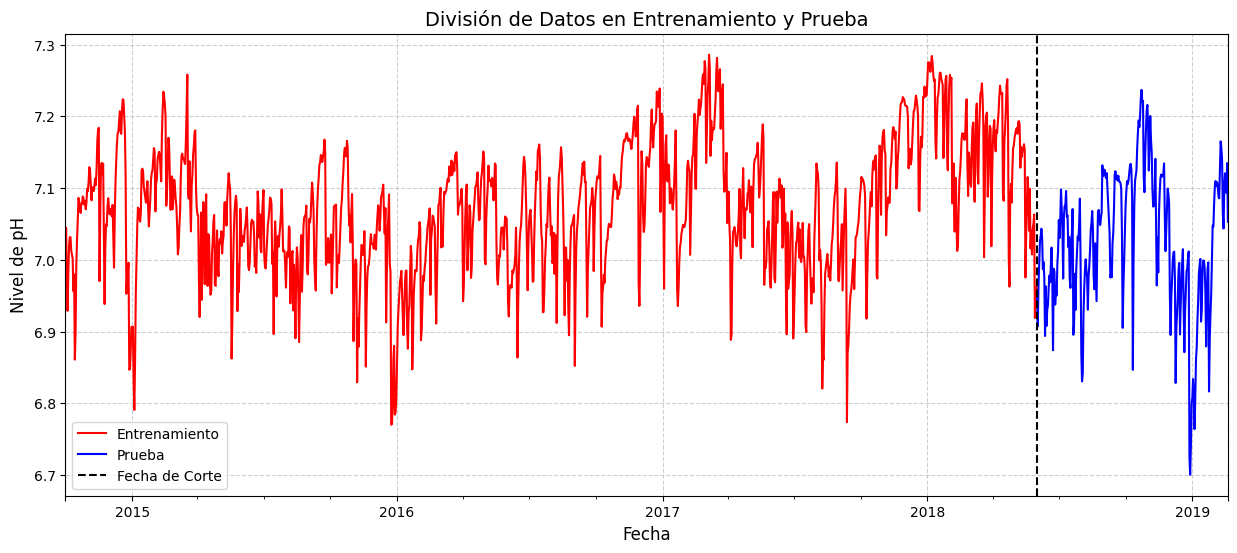

In [54]:
split_date = pd.Timestamp('2018-06-01')  # Define la fecha de separación entre entrenamiento y prueba

df_pH_series = df_pH['pH']  # Extrae la serie temporal de pH

train = df_pH.loc[:split_date]  # Conjunto de entrenamiento (datos antes de la fecha límite)
test = df_pH.loc[split_date:]  # Conjunto de prueba (datos a partir de la fecha límite)

plt.figure(figsize=(15, 6))  # Configura el tamaño del gráfico

ax = train['pH'].plot(color='red', label='Entrenamiento')  # Grafica los datos de entrenamiento en azul
test['pH'].plot(ax=ax, color='blue', label='Prueba')  # Grafica los datos de prueba en rojo sobre el mismo gráfico

plt.axvline(x=split_date, color='black', linestyle='--', label='Fecha de Corte')  # Línea vertical indicando el split
plt.title('División de Datos en Entrenamiento y Prueba', fontsize=14)  # Título del gráfico
plt.xlabel('Fecha', fontsize=12)  # Etiqueta del eje X
plt.ylabel('Nivel de pH', fontsize=12)  # Etiqueta del eje Y
plt.legend()  # Muestra la leyenda del gráfico
plt.grid(True, linestyle='--', alpha=0.6)  # Agrega una cuadrícula punteada

plt.show()  # Muestra el gráfico


## Normalización de datos

In [55]:


scaler = MinMaxScaler(feature_range=(-1, 1))  
# Inicializamos el escalador para normalizar los datos en el rango de -1 a 1

# Asegurar que 'train' sea un DataFrame o un array 2D
train = train.to_frame() if isinstance(train, pd.Series) else train  
# Si 'train' es una Serie, lo convertimos en DataFrame

train = np.array(train).reshape(-1, 1) if train.ndim == 1 else train  
# Si 'train' es unidimensional, lo transformamos en una matriz 2D

train_sc = scaler.fit_transform(train)  
# Aplicamos la normalización a los datos de entrenamiento

# Hacer lo mismo para 'test'
test = test.to_frame() if isinstance(test, pd.Series) else test  
test = np.array(test).reshape(-1, 1) if test.ndim == 1 else test  
test_sc = scaler.transform(test)  
# Normalizamos los datos de prueba con el mismo escalador


In [56]:
# Crear los datos de entrada (X) y salida (y) para el entrenamiento
X_train = train_sc[:-1]  # Toma todas las observaciones excepto la última
y_train = train_sc[1:]   # Toma todas las observaciones excepto la primera (desplazadas una posición)

# Crear los datos de entrada (X) y salida (y) para la prueba
X_test = test_sc[:-1]  # Toma todas las observaciones excepto la última
y_test = test_sc[1:]   # Toma todas las observaciones excepto la primera (desplazadas una posición)


## Modelo de Red Neuronal (Sequential)

Se crea una red neuronal simple con una capa oculta.

- Sequential() es una forma de construir modelos de redes neuronales en Keras. Se llama "secuencial" porque las capas se agregan una después de otra, en orden. Es el método más simple para definir una red neuronal en TensorFlow/Keras.

In [ ]:

# Definir el modelo de red neuronal
nn_model = Sequential()

# Capa oculta con 10 neuronas y activación ReLU
nn_model.add(Dense(10, input_dim=1, activation='relu'))

# Capa de salida con una sola neurona (predicción del siguiente valor)
nn_model.add(Dense(1))

# Compilar el modelo con pérdida de error cuadrático medio y optimizador Adam
nn_model.compile(loss='mean_squared_error', optimizer='adam')

# Implementar EarlyStopping para evitar sobreajuste
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1) # Si la pérdida no mejora en 2 épocas consecutivas, detiene el entrenamiento para evitar sobreajuste.

# Entrenar el modelo
history = nn_model.fit(
    X_train, y_train,  # Datos de entrada y salida
    epochs=100,        # Número de épocas
    batch_size=1,      # Tamaño del batch (se usa SGD por ser 1)
    verbose=1,         # Muestra información sobre el entrenamiento
    callbacks=[early_stop],  # Aplicar EarlyStopping
    shuffle=False      # No mezclar los datos para mantener la secuencia temporal
)


/home/julian/Documentos/TESIS/FUNDAMENTOS DE IA/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-02-22 17:38:26.990859: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/100
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 2s 945us/step - loss: 0.0597
Epoch 2/100
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 1s 964us/step - loss: 0.0320
Epoch 3/100
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 1s 923us/step - loss: 0.0309
Epoch 4/100
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 1s 976us/step - loss: 0.0305
Epoch 5/100
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 1s 977us/step - loss: 0.0303
Epoch 6/100
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 1s 939us/step - loss: 0.0302
Epoch 7/100
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 1s 970us/step - loss: 0.0301
Epoch 8/100
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 1s 971us/step - loss: 0.0300
Epoch 9/100
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 1s 996us/step - loss: 0.0300
Epoch 10/100
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 1s 961us/step - loss: 0.0299
Epoch 11/100
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 1s 950us/step - loss: 0.0298
Epoch 12/100
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 1s 959us/step - loss: 0.0297
Epoch 13/100
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0297
Epoch 14/100
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss

## Evaluación del Modelo

Después de entrenar nuestra red neuronal, evaluamos su precisión utilizando la métrica **R² (R cuadrado)**.



In [57]:

# Hacer predicciones en el conjunto de prueba
y_pred_test_nn = nn_model.predict(X_test)

# Hacer predicciones en el conjunto de entrenamiento
y_train_pred_nn = nn_model.predict(X_train)

# Calcular y mostrar el coeficiente de determinación (R²) para el conjunto de entrenamiento
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_nn)))

# Calcular y mostrar el coeficiente de determinación (R²) para el conjunto de prueba
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_nn)))


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
The R2 score on the Train set is:	0.733
The R2 score on the Test set is:	0.694


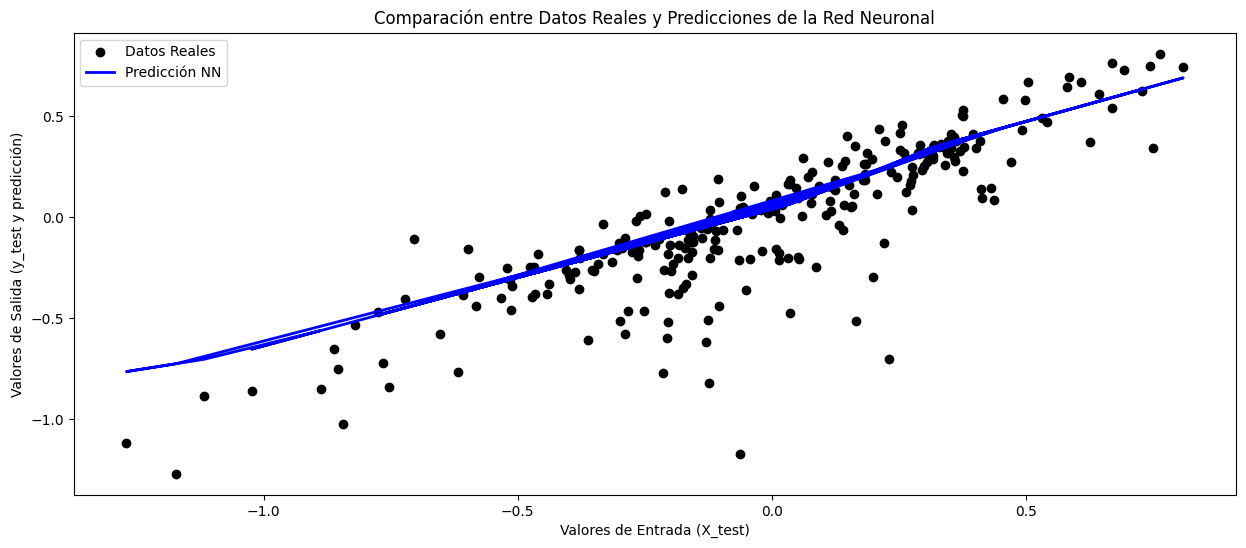

In [58]:

# Crear una figura con tamaño personalizado
plt.figure(figsize=(15, 6))

# Graficar los valores reales de prueba como puntos negros
plt.scatter(X_test, y_test, color='black', label='Datos Reales')

# Graficar las predicciones del modelo como una línea azul
plt.plot(X_test, y_pred_test_nn, color='blue', linewidth=2, label='Predicción NN')

# Etiquetas y leyenda
plt.xlabel('Valores de Entrada (X_test)')
plt.ylabel('Valores de Salida (y_test y predicción)')
plt.title('Comparación entre Datos Reales y Predicciones de la Red Neuronal')
plt.legend()

# Mostrar la gráfica
plt.show()


In [71]:

# Convertir los datos escalados de entrenamiento a un DataFrame
train_sc_df = pd.DataFrame(train_sc, columns=['Y'], index=train.index)

# Convertir los datos escalados de prueba a un DataFrame
test_sc_df = pd.DataFrame(test_sc, columns=['Y'], index=test.index)


In [72]:
# Crear variables de retraso (lag) en los datos escalados
for s in range(1, 2):  # En este caso, solo se genera un retraso (lag de 1)
    train_sc_df['X_{}'.format(s)] = train_sc_df['Y'].shift(s)  # Desplaza 'Y' en el tiempo
    test_sc_df['X_{}'.format(s)] = test_sc_df['Y'].shift(s)  # Hace lo mismo en los datos de prueba



In [73]:
# Eliminar filas con valores NaN (causados por el desplazamiento con shift())
train_sc_df = train_sc_df.dropna()

# Crear conjunto de entrenamiento (X_train) con las variables predictoras (lags)
X_train = train_sc_df.drop('Y', axis=1)  # Se eliminan los valores actuales de Y, dejando solo los lags

# Crear conjunto de entrenamiento (y_train) con la variable objetivo (Y)
y_train = train_sc_df.drop('X_1', axis=1)  # Se elimina X_1, dejando solo Y como objetivo


In [74]:
# Eliminar filas con valores NaN en el conjunto de prueba (test)
test_sc_df = test_sc_df.dropna()

# Crear conjunto de prueba (X_test) con las variables predictoras (lags)
X_test = test_sc_df.drop('Y', axis=1)  # Se eliminan los valores actuales de Y, dejando solo los lags

# Crear conjunto de prueba (y_test) con la variable objetivo (Y)
y_test = test_sc_df.drop('X_1', axis=1)  # Se elimina X_1, dejando solo Y como objetivo


In [75]:
# Convertir X_train de DataFrame de Pandas a un array de NumPy
X_train = X_train.values  

# Convertir y_train de DataFrame de Pandas a un array de NumPy
y_train = y_train.values  


In [76]:
# Convertir X_test de DataFrame de Pandas a un array de NumPy
X_test = X_test.values  

# Convertir y_test de DataFrame de Pandas a un array de NumPy
y_test = y_test.values  


In [29]:
X_train_lmse = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_lmse = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [77]:
# Imprimir la forma (shape) de los datos de entrenamiento
print('Train shape: ', X_train_lmse.shape)

# Imprimir la forma (shape) de los datos de prueba
print('Test shape: ', X_test_lmse.shape)


Train shape:  (1339, 1, 1)
Test shape:  (263, 1, 1)


## Modelo LSTM

Este código define, compila y entrena un modelo LSTM (Long Short-Term Memory) en Keras

In [78]:
# Importamos la API de modelos secuenciales de Keras
lstm_model = Sequential()  

# Añadimos una capa LSTM con 16 neuronas
lstm_model.add(LSTM(16,  
                    input_shape=(1, X_train_lmse.shape[1]),  # La entrada tiene 1 paso temporal y X_train_lmse.shape[1] características
                    activation='relu',  # Función de activación ReLU para mejorar el rendimiento
                    kernel_initializer='lecun_uniform',  # Inicialización de pesos para estabilidad
                    return_sequences=False))  # No devolvemos secuencias porque es la última capa LSTM

# Añadimos una capa densa con una neurona de salida
lstm_model.add(Dense(1))  # Capa de salida con 1 neurona (regresión, predicción de pH)

# Compilamos el modelo con la función de pérdida MSE y el optimizador Adam
lstm_model.compile(loss='mean_squared_error', optimizer='adam')

# Definimos la parada temprana para evitar sobreajuste
early_stop = EarlyStopping(monitor='loss',  # Monitorea la función de pérdida
                           patience=2,  # Si la pérdida no mejora en 2 épocas, detiene el entrenamiento
                           verbose=1)  # Muestra mensajes en la consola

# Entrenamos el modelo
history_lstm_model = lstm_model.fit(X_train_lmse, y_train,  # Datos de entrenamiento
                                    epochs=100,  # Número máximo de épocas
                                    batch_size=1,  # Entrenamos con 1 muestra por batch (ideal para series temporales)
                                    verbose=1,  # Muestra el progreso del entrenamiento
                                    shuffle=False,  # No mezclamos los datos porque son secuenciales
                                    callbacks=[early_stop])  # Aplicamos la parada temprana si es necesario


Epoch 1/100


/home/julian/Documentos/TESIS/FUNDAMENTOS DE IA/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1339/1339 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0926
Epoch 2/100
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0313
Epoch 3/100
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0304
Epoch 4/100
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0300
Epoch 5/100
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0298
Epoch 6/100
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0296
Epoch 7/100
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0295
Epoch 8/100
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0295
Epoch 9/100
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0294
Epoch 10/100
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0294
Epoch 11/100
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0294
Epoch 12/100
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0293
Epoch 13/100
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0293
Epoch 14/100
1339/1339 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0293
Epoch 15/100
1339/1339 ━━━━

## Evalución del modelo LSTM

In [79]:
# Hacemos predicciones en el conjunto de prueba
y_pred_test_lstm = lstm_model.predict(X_test_lmse)

# Hacemos predicciones en el conjunto de entrenamiento
y_train_pred_lstm = lstm_model.predict(X_train_lmse)

# Calculamos el coeficiente de determinación (R²) en los datos de entrenamiento
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_lstm)))

# Calculamos el coeficiente de determinación (R²) en los datos de prueba
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
The R2 score on the Train set is:	0.736
The R2 score on the Test set is:	0.706


## Analisis del rendimiento: NN vs. LSTM

In [80]:
# Evaluamos el error cuadrático medio (MSE) del modelo de red neuronal (NN) en el conjunto de prueba
nn_test_mse = nn_model.evaluate(X_test, y_test, batch_size=1)

# Evaluamos el error cuadrático medio (MSE) del modelo LSTM en el conjunto de prueba
lstm_test_mse = lstm_model.evaluate(X_test_lmse, y_test, batch_size=1)

# Imprimimos el error cuadrático medio para la red neuronal densa
print('NN: %f' % nn_test_mse)

# Imprimimos el error cuadrático medio para el modelo LSTM
print('LSTM: %f' % lstm_test_mse)


263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0359
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0357  
NN: 0.042529
LSTM: 0.040915


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


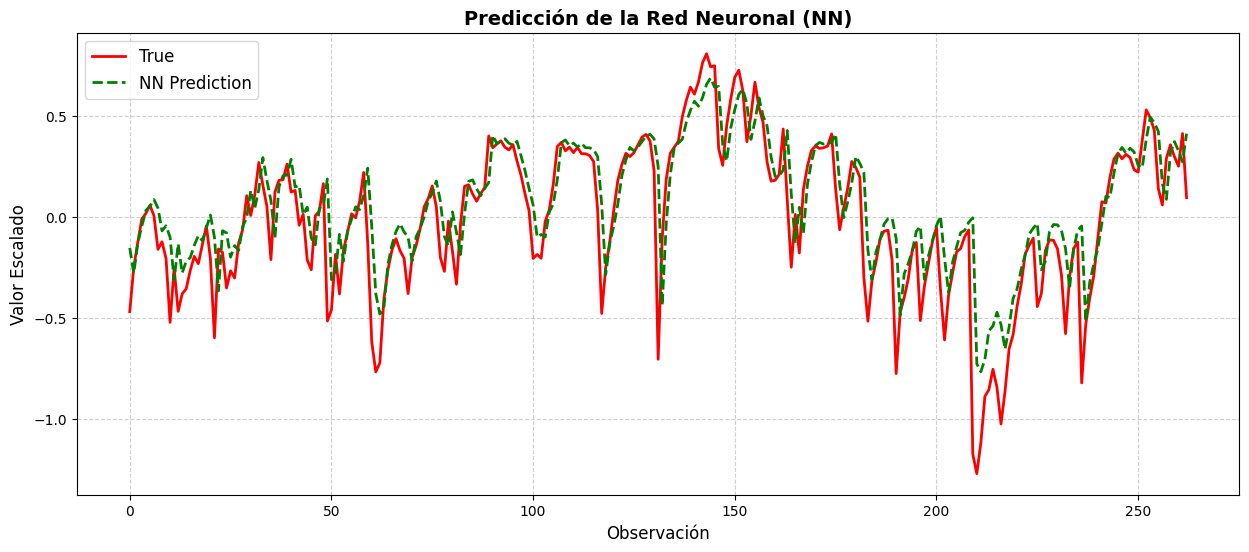

In [84]:
# Hacemos predicciones con la red neuronal en el conjunto de prueba
nn_y_pred_test = nn_model.predict(X_test)

# Hacemos predicciones con el modelo LSTM en el conjunto de prueba
lstm_y_pred_test = lstm_model.predict(X_test_lmse)

# Configuramos el tamaño del gráfico
plt.figure(figsize=(15, 6))

# Graficamos los valores reales con una línea negra discontinua
plt.plot(y_test, label='True', color='red', linestyle='solid', linewidth=2)

# Graficamos las predicciones del modelo de red neuronal en rojo con línea sólida
plt.plot(y_pred_test_nn, label='NN Prediction', color='green', linestyle='dashed', linewidth=2)

# Añadimos un título al gráfico
plt.title("Predicción de la Red Neuronal (NN)", fontsize=14, fontweight='bold')

# Etiqueta del eje X
plt.xlabel('Observación', fontsize=12)

# Etiqueta del eje Y
plt.ylabel('Valor Escalado', fontsize=12)

# Mejoramos la leyenda para que sea más clara
plt.legend(loc='upper left', fontsize=12)

# Agregamos una cuadrícula para mejor visualización
plt.grid(True, linestyle='--', alpha=0.6)

# Mostramos el gráfico
plt.show()


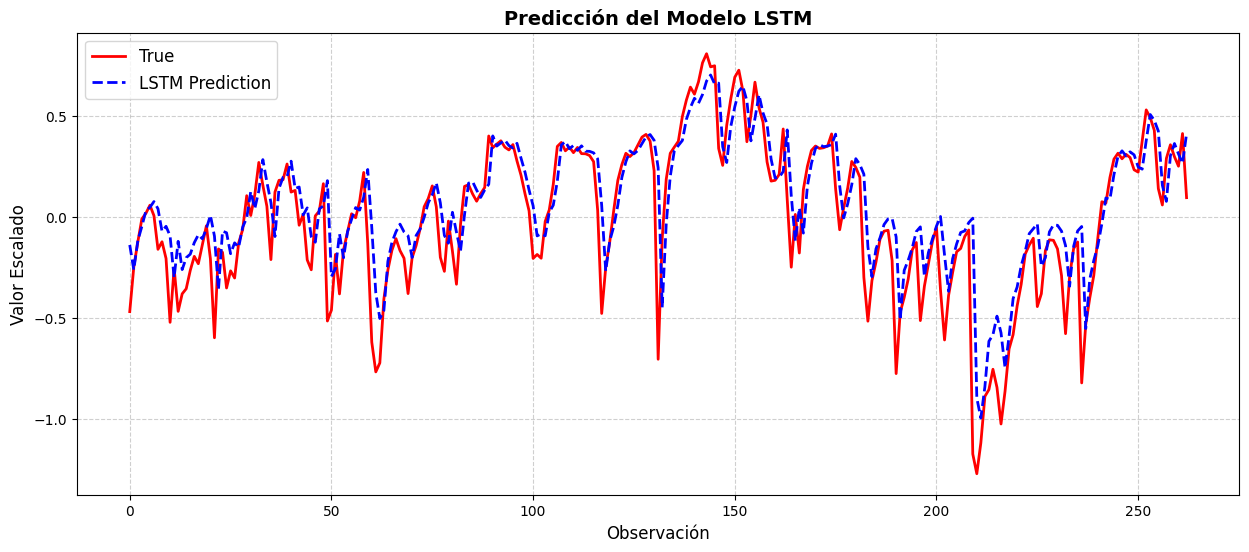

In [87]:
# Configuramos el tamaño del gráfico
plt.figure(figsize=(15, 6))

# Graficamos los valores reales con línea negra discontinua
plt.plot(y_test, label='True', color='red', linestyle='solid', linewidth=2)

# Graficamos las predicciones del modelo LSTM en rojo con línea sólida
plt.plot(y_pred_test_lstm, label='LSTM Prediction', color='blue', linestyle='dashed', linewidth=2)

# Añadimos un título al gráfico con fuente más grande y en negrita
plt.title("Predicción del Modelo LSTM", fontsize=14, fontweight='bold')

# Etiqueta del eje X con mejor formato
plt.xlabel('Observación', fontsize=12)

# Etiqueta del eje Y con mejor formato
plt.ylabel('Valor Escalado', fontsize=12)

# Mejoramos la leyenda y la ubicamos en la esquina superior izquierda
plt.legend(loc='upper left', fontsize=12)

# Agregamos una cuadrícula para mejorar la lectura del gráfico
plt.grid(True, linestyle='--', alpha=0.6)

# Mostramos el gráfico
plt.show()
